# Forward-backward scheduling
This notebook presents an implemntation of forward-backward scheduling for a simple task scheduling problem. It can load different projects from the [MPLIB](https://www.projectmanagement.ugent.be/research/project_scheduling/RCMPSP) library. It performs the forward-backward scheduling algorithm followed by a simple heruistic based on random number generation.

## Setup
Load packages, set up paths and environment. Load project instance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from parser import parse_mplib as psp

# random number generator with fixed seed
rng = np.random.default_rng(seed=43)

The data path with a full copy of the MPLIB library is required. The data path should be set in the `data_path` variable.

In [2]:
import os
datapath = "/Users/flo/Documents/MiM/Thesis/RCMPSP-LLM/data"
mplibpath = os.path.join(datapath, "MPLIB")
mplibvpath = {1: os.path.join(mplibpath, "MPLIB1"), 2: os.path.join(mplibpath, "MPLIB1/MPLIB2")}

The `mplibversion` can be set to 1 or 2, depending on the version of the MPLIB library you are using. The problem set and problem can then be selected accordingly.

In [45]:
mplibversion = 1
problem_set = 1
problem_n = 1

In [46]:
problempath = os.path.join(
	mplibvpath[mplibversion],
	"MPLIB {} - Set {}/Instances/MPLIB{}_Set{}_{}.rcmp".format(mplibversion, problem_set, mplibversion, problem_set, problem_n)
)
instance = psp(problempath)
instance

ProjectInstance(resources=[Resource(capacity=32, renewable=True, skills=None), Resource(capacity=31, renewable=True, skills=None), Resource(capacity=31, renewable=True, skills=None), Resource(capacity=32, renewable=True, skills=None)], activities=[Activity(modes=[Mode(duration=0, demands=[0, 0, 0, 0], skill_requirements=None)], successors=[1, 2, 3], predecessors=[], delays=None, optional=False, selection_groups=[], name='1:1'), Activity(modes=[Mode(duration=1, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[13, 12, 11, 8, 7, 4], predecessors=[0], delays=None, optional=False, selection_groups=[], name='1:2'), Activity(modes=[Mode(duration=1, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[12, 11, 9, 8, 7, 5], predecessors=[0], delays=None, optional=False, selection_groups=[], name='1:3'), Activity(modes=[Mode(duration=1, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[8, 7, 6], predecessors=[0], delays=None, optional=False, selection_gr

In [47]:
print("Loaded instance from MPLIB {}, set {}, problem {} with {} resources, {} activities and {} projects.".format(
    mplibversion, problem_set, problem_n, instance.num_resources, instance.num_activities, instance.num_projects))

Loaded instance from MPLIB 1, set 1, problem 1 with 4 resources, 372 activities and 6 projects.


The instance contains all information about the project:
- `num_resources`: number of resources
- `num_activities`: number of activities
- `num_projects`: number of projects
- `activities`: list of activities
- `resources`: list of resources
- `projects`: list of projects

In [48]:
instance.activities

[Activity(modes=[Mode(duration=0, demands=[0, 0, 0, 0], skill_requirements=None)], successors=[1, 2, 3], predecessors=[], delays=None, optional=False, selection_groups=[], name='1:1'),
 Activity(modes=[Mode(duration=1, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[13, 12, 11, 8, 7, 4], predecessors=[0], delays=None, optional=False, selection_groups=[], name='1:2'),
 Activity(modes=[Mode(duration=1, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[12, 11, 9, 8, 7, 5], predecessors=[0], delays=None, optional=False, selection_groups=[], name='1:3'),
 Activity(modes=[Mode(duration=1, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[8, 7, 6], predecessors=[0], delays=None, optional=False, selection_groups=[], name='1:4'),
 Activity(modes=[Mode(duration=7, demands=[10, 10, 10, 10], skill_requirements=None)], successors=[14, 9, 5], predecessors=[1], delays=None, optional=False, selection_groups=[], name='1:5'),
 Activity(modes=[Mode(duration=

### Get Earliest Start Times (EST) and Latest Finish Times (LFT)

The `mode_idx` is simply 0 since we only have one mode.

In [49]:
mode_idx = 0

 Then, calculate the earliest start time (EST) and earliest finish time (EFT) for each activity. The EST is the maximum of the finish times of all predecessors. The EFT is the EST plus the duration of the activity.

In [50]:
# pre initializing earliest and latest finish times
est, eft = {}, {}
for i in range(instance.num_activities):
    est[i] = 0
    eft[i] = 0
# calculating earliest start and finish times
for i in range(instance.num_activities):
    act = instance.activities[i]
    act_pre = instance.activities[i].predecessors
    est[i] = int(np.max([est[pre] + instance.activities[pre].modes[mode_idx].duration for pre in act_pre], initial=0))
    eft[i] = int(est[i] + act.modes[mode_idx].duration)

In [51]:
# est

Next, we want to calulcate initital LSTs and LFTs wtih backward recursion. The `upper_bound` is the sum of all durations. 

In [52]:
upper_bound = np.max([est[i] for i in range(instance.num_activities)])
upper_bound = np.sum([instance.activities[i].modes[mode_idx].duration for i in range(instance.num_activities)])
upper_bound

1992

In [53]:
# pre initializing earliest and latest finish times
lst, lft = {}, {}
# for i in range(instance.num_activities):
lst[instance.num_activities] = upper_bound
lft[instance.num_activities] = upper_bound
# define function to calculate latest start time
for i in range(instance.num_activities - 1, -1, -1):
    lft[i] = int(np.min([lst[suc] for suc in instance.activities[i].successors], initial=upper_bound))
    lst[i] = int(lft[i] - instance.activities[i].modes[mode_idx].duration)

In [54]:
# lst

Now, we can generate a serial schedule with a simple priority rule based on random selection. The `use_pr` enables the priority rule based on random selection.

In [55]:
use_pr = True

In [64]:
# pre initializing final variables
est_serial = {}
fin_schedule_serial = {}
start_schedule_serial = {}
scheduled = []

# first dummy activity can be scheduled
for j, act_j in enumerate(instance.activities):
    if act_j.modes[mode_idx].duration == 0 and len(act_j.predecessors) == 0:
        print("Activity {} has no predecessors and duration = 0, so a project start activity".format(j))
        scheduled.append(j)
        fin_schedule_serial[j] = 0
        start_schedule_serial[j] = 0
        
assert len(scheduled) == len(instance.projects), "Length of scheduled activities should be equal to the number of projects"

# the serial scheduling algorithm requires num_activities iterations
for i_act in range(instance.num_activities - len(scheduled)):

    # eligible activities are those that are not scheduled and whose predecessors are already scheduled
    eligible_activities = [j for j, act_j in enumerate(instance.activities) if j not in scheduled and set(act_j.predecessors) <= set(scheduled)]

    # in case no activities are eligible, the algorithm fails
    if not eligible_activities:
        print('No feasible schedule could be structured.')
        break
    
    print("Eligible activities: ", eligible_activities)
    # Priority rule: random number between 0 and 1
    pr = dict(zip(eligible_activities, rng.random(len(eligible_activities))))
    
        
    while pr:

        # priority rule based on random number            
        if use_pr:
            j = min(pr, key=pr.get)
            del pr[j]
            eligible_activities.remove(j)
        # priority rule based simple first element in list
        else:
            j = eligible_activities.pop(0)
            del pr[j]

        # get the mode of the activity and its duration
        act_j = instance.activities[j].modes[mode_idx]
        act_duration_j = act_j.duration

        # the earliest finish time is defined by the maximum of the finish times of all predecessors + the duration of the activity
        est_serial[j] = int(np.max([fin_schedule_serial[pre] for pre in instance.activities[j].predecessors], initial=0))
        
        # eligible times are the time slots between the earliest start time and the latest start time
        eligible_times = []
        for t in range(est_serial[j], lst[j] + 1):
            # check if it is possible to schedule at t (at least dummy activity should be scheduled)
            if t in fin_schedule_serial.values():
                is_eligible = True
                # check if the activity can be scheduled so that the resource constraints are not violated
                for r in range(instance.num_resources):
                    for moment in range(t, t + act_duration_j + 1):
                        active = [s for s in scheduled if fin_schedule_serial[s] > moment and start_schedule_serial[s] <= moment]
                        if act_j.demands[r] > instance.resources[r].capacity - sum([instance.activities[act_j].modes[mode_idx].demands[r] for act_j in active]):
                            is_eligible = False
                            break
                # if the activity can be scheduled, add the time to the list of eligible times
                if is_eligible:
                    eligible_times.append(t)
        
        # if there is any eligible time, schedule the activity at the earliest possible time
        if eligible_times:
            fin_schedule_serial[j] = np.min(eligible_times) + act_duration_j
            start_schedule_serial[j] = np.min(eligible_times)
            print("Scheduled activity {} at time {}.".format(j, fin_schedule_serial[j] - act_duration_j))
            scheduled.append(j)
            break

Activity 0 has no predecessors and duration = 0, so a project start activity
Activity 62 has no predecessors and duration = 0, so a project start activity
Activity 124 has no predecessors and duration = 0, so a project start activity
Activity 186 has no predecessors and duration = 0, so a project start activity
Activity 248 has no predecessors and duration = 0, so a project start activity
Activity 310 has no predecessors and duration = 0, so a project start activity
Eligible activities:  [1, 2, 3, 63, 64, 65, 125, 126, 127, 129, 130, 131, 133, 187, 188, 189, 191, 192, 193, 195, 249, 250, 255, 311, 312, 313]
Scheduled activity 127 at time 0.
Eligible activities:  [1, 2, 3, 63, 64, 65, 125, 126, 129, 130, 131, 133, 187, 188, 189, 191, 192, 193, 195, 249, 250, 255, 311, 312, 313]
Scheduled activity 131 at time 0.
Eligible activities:  [1, 2, 3, 63, 64, 65, 125, 126, 129, 130, 133, 187, 188, 189, 191, 192, 193, 195, 249, 250, 255, 311, 312, 313]
Scheduled activity 65 at time 0.
Eligible ac

After all activities are scheduled, we can calculate the total makespan. Since we have individual projects, we have to take the maximum of all finish times as makespan.

In [65]:
makespan = max(fin_schedule_serial.values())
print(f"Found makespan: {makespan} time units")

Found makespan: 673 time units


With the schedule, we can calculate the resource `usages` and the average utilization of each of the resources.

In [66]:
# pre initializing resource usages
usages = np.zeros((instance.num_resources, fin_schedule_serial[instance.num_activities - 1]))

# calculating resource usages
for idx, act in enumerate(instance.activities):
    for resource_idx, demand in enumerate(instance.activities[idx].modes[mode_idx].demands):
        usages[resource_idx, start_schedule_serial[idx] : fin_schedule_serial[idx]] += demand
        
resources = list(range(instance.num_resources))
for resource in resources:
    print(f"Resource {resource}:")
    print(f"\t Capacity: {instance.resources[resource].capacity}")
    print(f"\t Utilization: {np.sum(usages[resource]) / instance.resources[resource].capacity / len(usages[resource]) * 100:.2f}%")
    print(f"\t Max usage: {np.sum(usages[resource] == instance.resources[resource].capacity) / len(usages[resource]) * 100:.2f}%")
    print(f"\t 80% usage: {np.sum(usages[resource] > 0.5*instance.resources[resource].capacity) / len(usages[resource]) * 100:.2f}%")
    print(f"\t Zero usage: {np.sum(usages[resource] == 0) / len(usages[resource]) * 100:.2f}%")
    print()

Resource 0:
	 Capacity: 32
	 Utilization: 78.22%
	 Max usage: 0.00%
	 80% usage: 83.88%
	 Zero usage: 0.00%

Resource 1:
	 Capacity: 31
	 Utilization: 79.70%
	 Max usage: 6.20%
	 80% usage: 83.88%
	 Zero usage: 0.00%

Resource 2:
	 Capacity: 31
	 Utilization: 79.82%
	 Max usage: 5.89%
	 80% usage: 83.88%
	 Zero usage: 0.00%

Resource 3:
	 Capacity: 32
	 Utilization: 78.17%
	 Max usage: 0.00%
	 80% usage: 83.88%
	 Zero usage: 0.00%



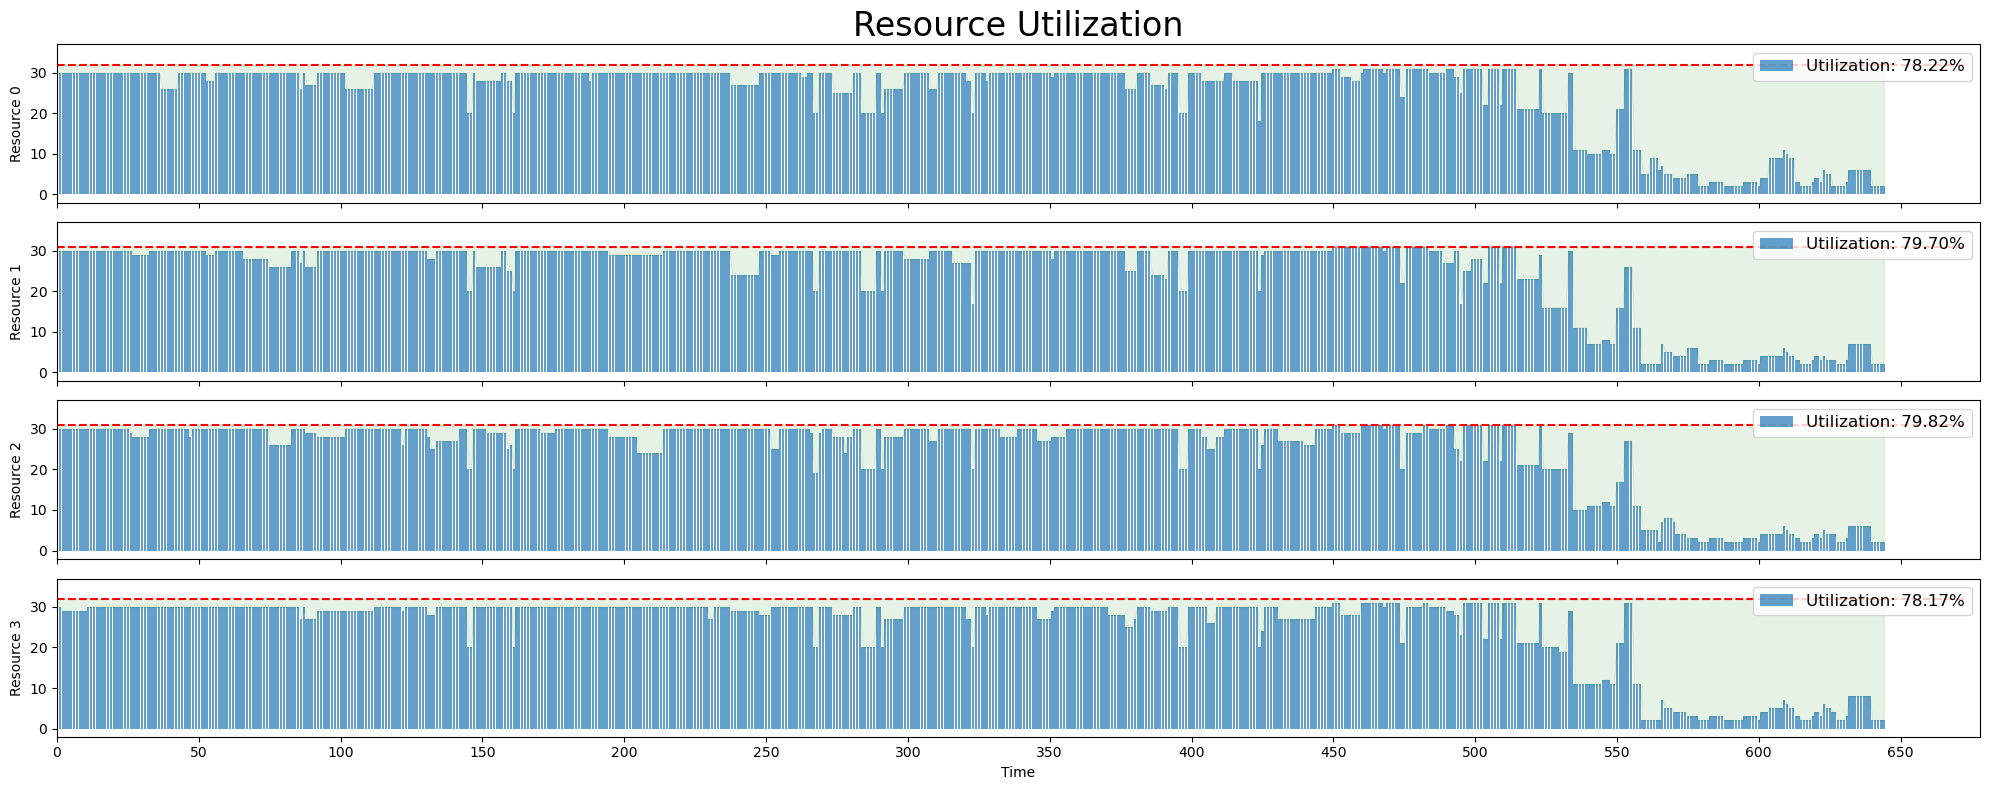

In [67]:
fig, axes = plt.subplots(instance.num_resources, figsize=(20, 8), sharex=True)

resources = list(range(instance.num_resources))

min_cap = np.min([instance.resources[r].capacity for r in resources])
max_cap = np.max([instance.resources[r].capacity for r in resources])

for resource in resources:
    usage = usages[resource]
    ax = axes[resource]
    time = np.arange(len(usage))
    label = f"Resource {resource}"

    ax.bar(time, usage, edgecolor='none', label=f"Utilization: {np.sum(usage) / instance.resources[resource].capacity / len(usages[resource]) * 100:.2f}%", alpha=0.7)
    ax.hlines(instance.resources[resource].capacity, 0, makespan, color="red", linestyle="--")
    ax.fill_between(
        time,
        usage,
        instance.resources[resource].capacity,
        where=usage >= instance.resources[resource].capacity,
        color="red",
        alpha=0.1,
    )
    ax.fill_between(
        time,
        usage,
        instance.resources[resource].capacity,
        where=usage <= instance.resources[resource].capacity,
        color="green",
        alpha=0.1,
    )
    ax.set_ylabel(label)
    ax.set_ylim(-2, max_cap + 5)
    ax.legend(loc="upper right", fontsize=12)

ax.set_xticks(np.arange(0, makespan, 50))
ax.set_xlim(0, makespan + 5)
ax.set_xlabel("Time")
axes[0].set_title("Resource Utilization", fontsize=24)
plt.tight_layout()  # Optional: adjust layout to avoid clipping

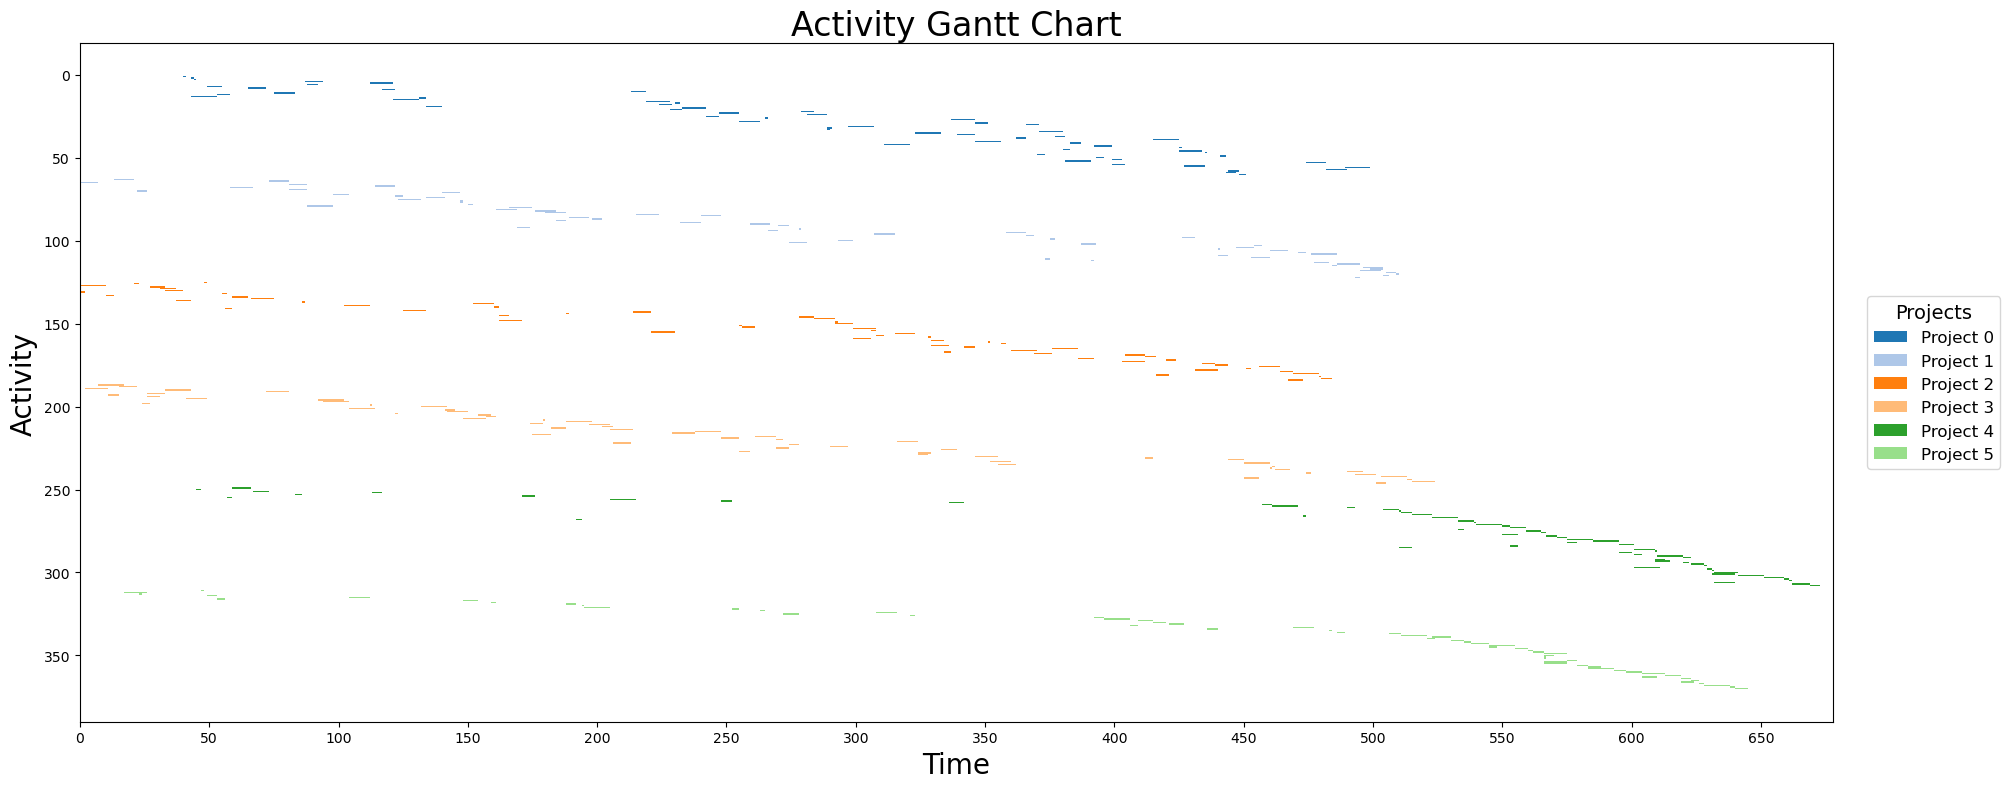

In [68]:
plot_labels = False
color_projects = True

fig, ax = plt.subplots(figsize=(20, 8))

tasks = list(range(instance.num_activities))
projects = list(range(instance.num_projects))

colors = plt.cm.tab20.colors  # Use a qualitative colormap for task colors

# Keep track of which projects have already been added to the legend
handles = {}

for idx, act in enumerate(instance.activities):
    start = start_schedule_serial[idx]
    end = fin_schedule_serial[idx]
    duration = act.modes[mode_idx].duration

    color = colors[idx % len(colors)]
    proj = [p for p in projects if idx in instance.projects[p].activities][0]
    if color_projects:
        color = colors[proj % len(colors)]
    
    handle = ax.barh(
                idx,
                duration,
                left=start,
                align="center",
                color=color,
                edgecolor="none",
                linewidth=5.5,
                label=f"Project {proj}",
            )
    if proj not in handles:
        handles[proj] = handle  # Store the handle for this project

    if plot_labels:
        ax.text(
            x=(start + end) / 2,
            y=idx + 0.1,
            s=f"{idx}",
            va="center",
            ha="center",
            color="black",
        )


if color_projects:
    ax.legend(
        handles=handles.values(),  # Pass the unique handles to the legend
        loc='center right', 
        bbox_to_anchor=(1.1, 0.5),
        fontsize=12,
        title="Projects",
        title_fontsize=14,
    )
ax.set_xlabel("Time", fontsize=20)
ax.set_xticks(np.arange(0, makespan + 5, 50))
ax.set_xlim(0, makespan + 5)
ax.set_ylabel("Activity", fontsize=20)
ax.set_title("Activity Gantt Chart", fontsize=24)
ax.invert_yaxis()
plt.tight_layout()  # Optional: adjust layout to avoid clipping

Text(0.5, 1.0, 'Solution')

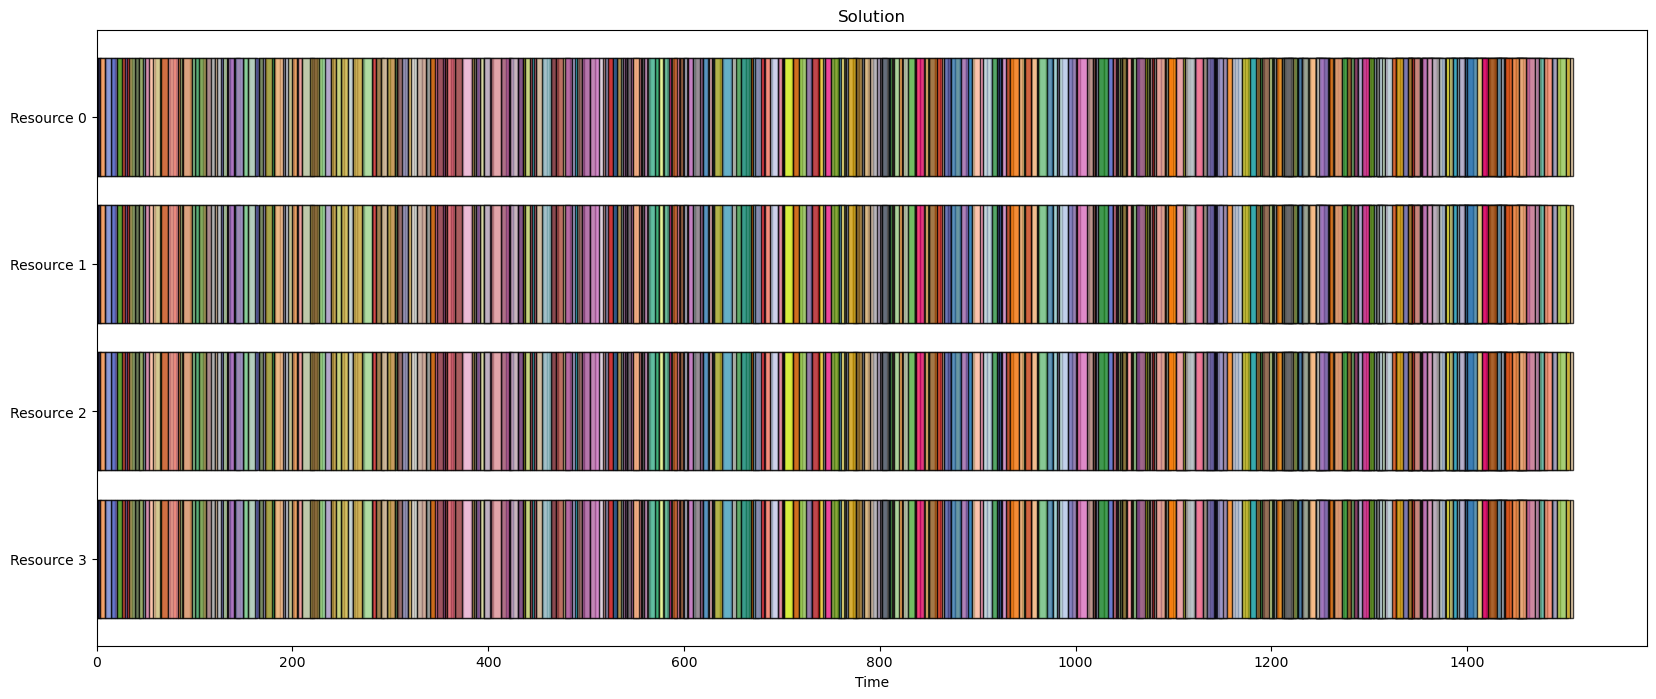

In [16]:
plot_labels = False

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

resources = list(range(instance.num_resources))

task2color = {}

col_names = ["tab20c", "Dark2", "Set1", "tab20b", "Set2", "tab20", "Accent"]
cmaps = [matplotlib.colormaps[name] for name in col_names]
colors = list(dict.fromkeys([color for cmap in cmaps for color in cmap.colors]))

for idx, act in enumerate(instance.activities):
    kwargs = {
        "color": colors[idx % len(colors)],
        "linewidth": 1,
        "edgecolor": "black",
        "alpha": 0.75,
    }
    duration = act.modes[mode_idx].duration
    for resource in range(instance.num_resources):
        if act.modes[mode_idx].demands[resource] > 0:

            ax.barh(
                resource,
                duration,
                left=start_schedule_serial[idx],
                **kwargs,
            )

            if plot_labels:
                ax.text(
                    start_schedule_serial[idx] + duration / 2,
                    resource,
                    f"{idx}",
                    ha="center",
                    va="center",
                )

labels = [f"Resource {idx}" for idx in resources]

ax.set_yticks(ticks=range(len(labels)), labels=labels)
ax.set_ylim(ax.get_ylim()[::-1])

ax.set_xlim(0, ax.get_xlim()[1])  # start time at zero
ax.set_xlabel("Time")
ax.set_title("Solution")

# Graph visiualization using `pyvis`

In [19]:
from pyvis import network as net
import networkx as nx

In [20]:
# define hex colors for projects
hex_colors = [matplotlib.colors.to_hex(color) for color in plt.cm.tab20.colors]
project_colors = {i: hex_colors[i % len(hex_colors)] for i in range(instance.num_projects)}

# create a directed graph
g = net.Network(notebook=True, height="1000px", width="100%", cdn_resources="in_line", directed=False, filter_menu=False, select_menu=False)

# add nodes for each activity
g.add_nodes(list(range(instance.num_activities)),
                        label=[f"Activity {idx}" for idx in range(instance.num_activities)], 
                        value=[act.modes[mode_idx].duration for act in instance.activities],
                        title=["Demands: {}".format(act.modes[mode_idx].demands) for act in instance.activities],
                        color=[hex_colors[[p for p in projects if idx in instance.projects[p].activities][0]] for idx in range(instance.num_activities)]
                        )

# add edges for each activity
for idx, act in enumerate(instance.activities):
    for succ in act.successors:
        g.add_edge(idx, succ, color=project_colors[[p for p in projects if idx in instance.projects[p].activities][0]], title=f"Activity {idx} -> Activity {succ}")
g.set_edge_smooth('dynamic')
g.toggle_physics(True)
# g.show_buttons(filter_=['physics', 'layout'])
# g.show_buttons()
g.set_options("""const options = {
"nodes": {
    "borderWidth": 2,
    "borderWidthSelected": 5,
    "font": {
        "face": "tahoma"
    },
    "size": null
},
"edges": {
    "color": {
        "inherit": true
    },
    "font": {
        "strokeWidth": 5
    },
    "selfReferenceSize": null,
    "selfReference": {
    "angle": 0.7853981633974483
    },
    "smooth": false
},
"layout": {
    "hierarchical": {
        "enabled": false,
        "levelDistance": 150,
        "nodeSpacing": 200,
        "treeSpacing": 20,
        "blockShifting": true,
        "edgeMinimization": true,
        "parentCentralization": true
    }
}
}""")

In [21]:
g.show("mplib_network.html")

mplib_network.html
